In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns

In [2]:
# Load data
df = pd.read_csv("../data/SPX.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Price = df.loc[:,"Adj Close"]

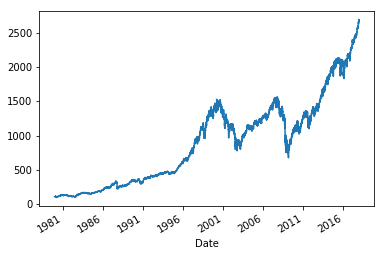

In [3]:
Price=Price.loc[(Price.index>"1980-01-01") & (Price.index<"2018-01-01")]
Volume = df.loc[:,"Volume"]
Price.plot()
plt.show()

# Micro-regime detection 

## 0. Summary
### 0.1 Basic idea

* Use the measure based on daily PNL of the basic (momentum) ema bollingerBands strategy (details in **1.1, 1.2**), to represent the direction and extent of market regime.
* Find the trading strategy parameters which make the positive/negative daily PNLs are relatively densely distributed. (which means these parameters make trading strategy better catch the market regime) (details in **1.3, 1.4**)
* Build and test simple indicator to predict the market regime measure. (details in **2.**)

### 0.2 Progress
* Backtested baseline momentum and mean-reversion strategies.
* Built and tested simple indicator for market regime. 

### 0.3 Problem and Plan
* We are still trying to build a measure to describe the extremity of daily PNL (the density that all the positive/negtive data distributed nearby), to select parameter quantitatively.
* The correlation is unsatisifying, which means at least the individual indicator or the linear combination of indicators could not be a good indicator for regime detection. We hope to test other technical indicators, self-defined indicators and non-linear combination in the next stage.
* The unsatisifying correlation might also result from the data itself. The technical indicator should have be much more useful for minite data or second data instead of daily data.

## 1. Backtest baseline momentum and mean-reversion strategies: 

### 1.1 Signals:
"EMA"(short_window)  
  * EMA = [short_window]-bar exponential moving average                 
"BollingerBands"(long_window, num_std) 
  * Middle Band = [long_window]-bar simple moving average (SMA) 
  * Upper Band = [long_window]-bar SMA + ( [long_window]-bar standard deviation of price x [num_std]) 
  * Lower Band = [long_window]-bar SMA - ( [long_window]-bar standard deviation of price x [num_std]) 

In [4]:
def compute_ema(series=Price, short_window=5):
    return series.ewm(span=short_window,adjust=False).mean()

In [5]:
def compute_bollinger_band(series=Price, long_window=20, num_std=1):
    bollinger_band_middle = series.rolling(window = long_window).mean()
    rolling_std = series.rolling(window = long_window).std()
    bollinger_band_upper = bollinger_band_middle+rolling_std*num_std
    bollinger_band_lower = bollinger_band_middle-rolling_std*num_std
    return bollinger_band_upper,bollinger_band_middle, bollinger_band_lower

### 1.2 Strategies: 
Momentum:  
long if EMA crosses over Upper Band             
        -close if EMA crosses down below Middle Band       
short if EMA crosses down below Upper Band                  
        -close if EMA crosses from below Middle Band           
                   
Mean-reversion:              
long if EMA crosses over Upper Band             
        -close if EMA crosses down below Middle Band       
short if EMA crosses down below Upper Band                  
        -close if EMA crosses from below Middle Band         

In [6]:
def ema_boll_strategy(series=Price, short_window=5, long_window=20, num_std=1,market_regime=1):
    """
    """
    ema = compute_ema(series, short_window)
    bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, long_window, num_std)
    position = pd.Series(None,index = series.index)
    mask_up_open = ema>=bb_upper
    position.loc[mask_up_open] = market_regime
    mask_down_open = ema<=bb_lower
    position.loc[mask_down_open] = -market_regime
    mask_close = ( (ema.shift()>=bb_middle.shift())&(ema<bb_middle) )|( (ema.shift()<=bb_middle.shift())&(ema>bb_middle) )
    position.loc[mask_close] = 0
    position.fillna(method="ffill",inplace=True)
    position.fillna(0,inplace=True)
    return position.astype(np.int)

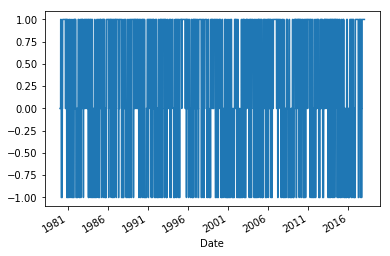

In [7]:
position = ema_boll_strategy(series=Price, short_window=5, long_window=20, num_std=1,market_regime=1)
position.plot()
plt.show()

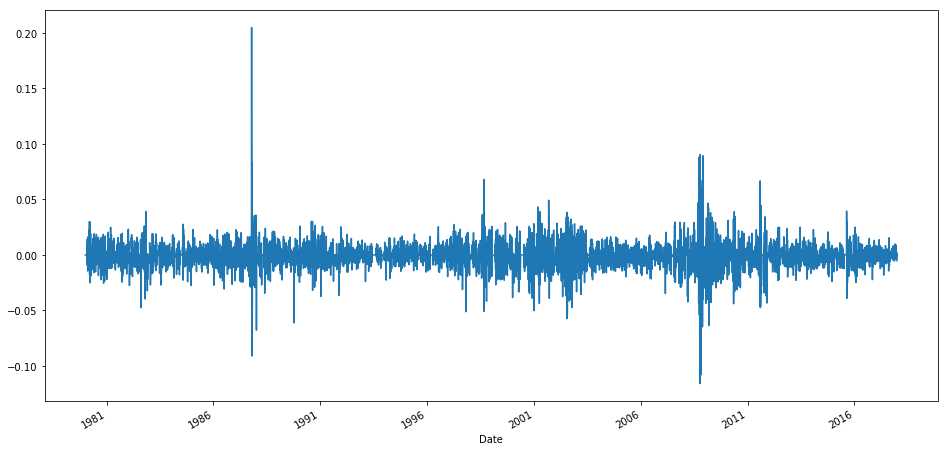

In [8]:
def compute_PNL(price = Price, position=position, reinvest = False):
    return_rate = price.shift(-1)/price - 1
    if reinvest:
        wealth_change = (1+position*return_rate)
        PNL = wealth_change.cumprod()
    else:
        PNL = (position*return_rate).cumsum()
    return PNL
PNL = compute_PNL(price = Price, position=position)
PNL.diff().plot(figsize=(16,8))
plt.show()

### 1.3 Parameter: 
Slightly adjust short_window, long_window and num_std for specific assets (try SPY first) to find the parameters for extreme profit and loss for different time period.   

In [9]:
short_window_list = [1,2,3,4,5]
long_window_list = range(12,30,1)
num_std_list = ["%.1f"%x for x in np.arange(0.8,1.6+1e-6,0.1)]
num_back_tests=len(short_window_list)*len(long_window_list)*len(num_std_list)

back_tests_list = [None] * num_back_tests
parameters_list = [None] * num_back_tests
i=0
for short_window in short_window_list:
    for long_window in long_window_list:
        for num_std_ in num_std_list:
            parameters_list[i] = (short_window,long_window,num_std_)
            num_std = np.float(num_std_)
            position = ema_boll_strategy(series=Price, short_window=short_window, long_window=long_window, num_std=num_std,market_regime=1)
            back_tests_list[i] = compute_PNL(price = Price, position=position)
            i += 1

In [10]:
dict_parameters_idx = dict(zip(parameters_list,range(num_back_tests))) 

In [11]:
f2 = np.zeros(num_back_tests)
f3 = np.zeros(num_back_tests)
ratio = np.zeros(num_back_tests)
for i in range(num_back_tests):
    dailyPNL = back_tests_list[i].diff()
    dailyPNL = dailyPNL[dailyPNL.abs()>1e-5]
    f2[i] = dailyPNL.rolling(window=3).mean().abs().mean()*1e4
    f3[i] = dailyPNL.abs().rolling(window=3).mean().mean()*1e4
ratio = f2/f3

In [12]:
import sortedcontainers

In [13]:
dict_ratio_idx= sortedcontainers.SortedDict(zip(-ratio,range(num_back_tests)))

In [14]:
#for rat, idx in dict_ratio_idx.items():
#    back_tests_list[idx].plot(title = str(parameters_list[idx])+";  ratio=%.2f"%-rat,figsize = (16,8))
#    plt.show()    

**By manually picking, (7,28,"0.8") is a good choice**

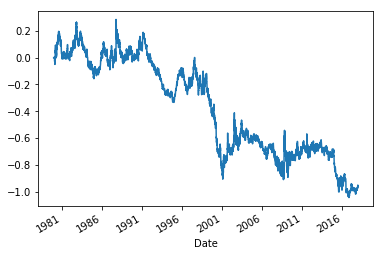

In [15]:
short_window = 1
long_window = 28
num_std = 0.9
back_test_selected = back_tests_list[dict_parameters_idx[(short_window,long_window,str(num_std))]]
back_test_selected.plot()
daily_pnl = back_test_selected.diff()
plt.show()

### 1.4 MEASURE for the extremity of daily PNL:
I am still trying to build a measure to describe the extremity of daily PNL (the density that all the positive/negtive data standed nearby), to select parameter quantitatively. I am trying to build the measure based on the following basic statistics, but do not have a clear idea now.
 * "Sharp Ratio"
 * "Range": max PNL - min PNL
 * "Interquartile Range"
 * "Volatility": std of PNL

In [16]:
def compute_sharpe(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return(np.mean(ret)/np.std(ret))

In [17]:
def compute_range(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return max(ret) - min(ret)

In [18]:
def compute_interquartile(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return np.percentile(ret,75)-np.percentile(ret,25)

In [19]:
def compute_vol(arr):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    vol = np.float(np.sqrt(np.cov(return_arr)))
    return vol

## 2. Build regime indicator 
### 1.1 Indicator 
 * “Hurst Exponent” : a measure of long-term memory of time series related to the autocorrelations       
 * “Sharp Ratio”             
 * “Long short scale volatility ratio” : long-scale volatility / short-scale volatility        
 * “Autocorrelations”: Autocorrelations for different lag                       

In [20]:
def compute_hurst_exponent(arr):
    num_lag = 18
    lag_arr = np.arange(2,2+num_lag)
    tau_arr = np.zeros(num_lag)
    #  Step through the different lags
    for i in range(num_lag):
        lag = lag_arr[i]
        #  produce price difference with lag
        arr_diff = np.diff(arr,lag)
        #  Calculate the variance of the differnce vector
        tau_arr[i] = np.sqrt(np.std(arr_diff))
    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lag_arr),np.log10(tau_arr),1)
    # calculate hurst
    hurst = m[0]*2
    return hurst

In [21]:
"""
def compute_vol(arr):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    vol = np.float(np.sqrt(np.cov(return_arr)))
    return vol
"""
def compute_long_short_scale_vol_ratio(arr, long_scale ,short_scale=1):
    arr_long_scale = arr[::long_scale]
    arr_short_scale = arr[::short_scale]
    
    return compute_vol(arr_short_scale)/compute_vol(arr_long_scale)

In [22]:
def compute_autocorr(arr, lag):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    mat_autocov = np.cov(return_arr[lag:],return_arr[:-lag])
    autocorr = mat_autocov[1,0]/np.sqrt(mat_autocov[0,0]*mat_autocov[1,1])
    return autocorr

In [23]:
"""
def compute_sharpe(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return(np.mean(ret)/np.std(ret))
"""

'\ndef compute_sharpe(arr):\n    ret = np.divide(np.diff(arr),arr[:-1])\n    return(np.mean(ret)/np.std(ret))\n'

In [24]:
window_indicators = 30
Indicators = pd.DataFrame(index = Price.index, columns=["hurst_exponent",
                                                        "long_short_scale_vol_ratio_2",
                                                        "long_short_scale_vol_ratio_3",
                                                        "long_short_scale_vol_ratio_4",
                                                        "long_short_scale_vol_ratio_5",
                                                        "autocorr_1",
                                                        "autocorr_2",
                                                        "autocorr_3",
                                                        "autocorr_4",
                                                        "autocorr_5",
                                                        "autocorr_6",
                                                        "autocorr_7",
                                                        "sharpe_ratio",
                                                        "PVT",
                                                        "Volume"])
Indicators.loc[:,"hurst_exponent"] = Price.rolling(window=window_indicators).apply(compute_hurst_exponent)
Indicators.loc[:,"long_short_scale_vol_ratio_2"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,2))
Indicators.loc[:,"long_short_scale_vol_ratio_3"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,3))
Indicators.loc[:,"long_short_scale_vol_ratio_4"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,4))
Indicators.loc[:,"long_short_scale_vol_ratio_5"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,5))
Indicators.loc[:,"autocorr_1"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,1))
Indicators.loc[:,"autocorr_2"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,2))
Indicators.loc[:,"autocorr_3"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,3))
Indicators.loc[:,"autocorr_4"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,4))
Indicators.loc[:,"autocorr_5"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,5))
Indicators.loc[:,"autocorr_6"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,6))
Indicators.loc[:,"autocorr_7"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,7))
Indicators.loc[:,"sharpe_ratio"] = Price.rolling(window=window_indicators).apply(compute_sharpe)
Indicators.loc[:,"PVT"] = ((Price/Price.diff()-1)*Volume/1e10).rolling(window=10).mean()
Indicators.loc[:,"Volume"] = Volume
Indicators.loc[:,"Price"] = Price


In [25]:
df_dropna = Indicators.dropna()
df_dropna

,hurst_exponent,long_short_scale_vol_ratio_2,long_short_scale_vol_ratio_3,long_short_scale_vol_ratio_4,long_short_scale_vol_ratio_5,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,autocorr_6,autocorr_7,sharpe_ratio,PVT,Volume,Price
Date,,,,,,,,,,,,,,,,
1980-02-12,5.227583,1.017808,0.625853,0.655535,0.797050,-0.524758,0.392508,-0.212275,-0.127350,0.178149,-0.399989,0.358279,0.507178,0.337682,48090000,117.900002
1980-02-13,5.270584,0.965553,0.800387,0.737335,0.462848,-0.498126,0.375006,-0.107816,-0.147073,0.221462,-0.434918,0.349632,0.566490,0.428446,65230000,118.440002
1980-02-14,5.289097,1.062136,0.867463,0.687014,0.930216,-0.463824,0.248651,0.050036,-0.287750,0.205960,-0.475350,0.308826,0.406430,0.466642,50540000,116.720001
1980-02-15,5.310142,0.960742,0.680145,0.541525,0.597402,-0.277929,0.226882,0.025417,-0.165549,0.092771,-0.459897,0.232118,0.327229,0.369623,46680000,115.410004
1980-02-19,5.323241,0.746274,1.497506,0.572923,0.722823,-0.197007,0.258891,0.037835,-0.227275,0.101150,-0.521734,0.312696,0.228173,0.379481,39480000,114.599998
1980-02-20,5.309858,0.839393,0.638758,0.507544,1.135375,-0.250301,0.120683,-0.114703,-0.195224,0.125857,-0.582639,0.393639,0.280676,0.241489,44340000,116.470001
1980-02-21,5.275711,0.809521,0.487133,0.597513,0.847972,-0.312766,0.165094,-0.032107,-0.040622,0.126657,-0.595800,0.430369,0.199610,0.134860,51530000,115.279999
1980-02-22,5.253215,0.871426,1.397679,0.531887,0.463607,-0.277484,0.135520,-0.016766,-0.016643,0.152581,-0.593154,0.412227,0.189461,-0.215923,48210000,115.040001
1980-02-25,5.234921,0.794376,0.698223,0.642079,0.456521,-0.242954,0.214614,-0.120876,0.053856,0.242439,-0.339371,0.389223,0.105809,-0.282542,39140000,113.330002


### 1.2 Constructing Training Set and Test Set

In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [27]:
columns=Indicators.columns

In [28]:
window = 22
num_features = 15

In [29]:
y = daily_pnl.rolling(window=window).mean().dropna()
df_dropna = df_dropna.iloc[:,:num_features].reindex(y.index).dropna()
y = y.reindex(df_dropna.index)
X = np.zeros((len(y.index),num_features*window))

In [30]:
df_dropna

,hurst_exponent,long_short_scale_vol_ratio_2,long_short_scale_vol_ratio_3,long_short_scale_vol_ratio_4,long_short_scale_vol_ratio_5,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,autocorr_6,autocorr_7,sharpe_ratio,PVT,Volume
Date,,,,,,,,,,,,,,,
1980-02-12,5.227583,1.017808,0.625853,0.655535,0.797050,-0.524758,0.392508,-0.212275,-0.127350,0.178149,-0.399989,0.358279,0.507178,0.337682,4.809000e+07
1980-02-13,5.270584,0.965553,0.800387,0.737335,0.462848,-0.498126,0.375006,-0.107816,-0.147073,0.221462,-0.434918,0.349632,0.566490,0.428446,6.523000e+07
1980-02-14,5.289097,1.062136,0.867463,0.687014,0.930216,-0.463824,0.248651,0.050036,-0.287750,0.205960,-0.475350,0.308826,0.406430,0.466642,5.054000e+07
1980-02-15,5.310142,0.960742,0.680145,0.541525,0.597402,-0.277929,0.226882,0.025417,-0.165549,0.092771,-0.459897,0.232118,0.327229,0.369623,4.668000e+07
1980-02-19,5.323241,0.746274,1.497506,0.572923,0.722823,-0.197007,0.258891,0.037835,-0.227275,0.101150,-0.521734,0.312696,0.228173,0.379481,3.948000e+07
1980-02-20,5.309858,0.839393,0.638758,0.507544,1.135375,-0.250301,0.120683,-0.114703,-0.195224,0.125857,-0.582639,0.393639,0.280676,0.241489,4.434000e+07
1980-02-21,5.275711,0.809521,0.487133,0.597513,0.847972,-0.312766,0.165094,-0.032107,-0.040622,0.126657,-0.595800,0.430369,0.199610,0.134860,5.153000e+07
1980-02-22,5.253215,0.871426,1.397679,0.531887,0.463607,-0.277484,0.135520,-0.016766,-0.016643,0.152581,-0.593154,0.412227,0.189461,-0.215923,4.821000e+07
1980-02-25,5.234921,0.794376,0.698223,0.642079,0.456521,-0.242954,0.214614,-0.120876,0.053856,0.242439,-0.339371,0.389223,0.105809,-0.282542,3.914000e+07


In [31]:
for i in range(window-1,len(y.index)):
    # transform the feature matrix for a certain window into a vector
    X[i,:] = df_dropna.iloc[i-window+1:i+1,:num_features].values.reshape(1,-1)

In [32]:
# shift the length of a window
X = X[window-1:-window,:]
y = y[window-1:-window]
y_positive = (y>0)

In [33]:
y_positive.shape

(9401,)

In [34]:
# split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_positive, test_size =500, random_state=13)

### 1.3 Simple Classifier 1 : SVM on transformed feature vector

In [35]:
# LOSS = "HINGE" for svm
sgd_clf = SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
                       eta0=0.0, fit_intercept=True, l1_ratio=0.5,
                       learning_rate='optimal', loss='hinge', max_iter=60, n_iter=None,
                       n_jobs=-1, penalty='elasticnet', power_t=0.5, random_state=13, shuffle=True,
                       tol=None, verbose=0, warm_start=False)

In [36]:
sgd_clf.fit(X_train, y_train)
train_score = sgd_clf.score(X_train, y_train)
print("Accuracy in train set: %.4f%%"%(train_score*100))

Accuracy in train set: 54.5781%


In [37]:
test_score = sgd_clf.score(X_test, y_test)
print("Accuracy in test set: %.4f%%"%(test_score*100))

Accuracy in test set: 54.8000%


### 1.4 Random Forests on transformed feature vector

#### Train & Test

In [38]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
rnd_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
rnd_clf.fit(X_train, y_train)
train_score = rnd_clf.score(X_train, y_train)
print("Accuracy in train set: %.4f%%"%(train_score*100))

Accuracy in train set: 81.7886%


In [40]:
test_score = rnd_clf.score(X_test, y_test)
print("Accuracy in test set: %.4f%%"%(test_score*100))

Accuracy in test set: 81.8000%


In [41]:
impt = rnd_clf.feature_importances_.reshape(window,num_features)

In [42]:
highest_part = impt[impt>np.percentile(impt,95)]

In [43]:
# the weights on sharp ratio is too large, so we transform the top 5% values to better visualize the result
impt[impt>np.percentile(impt,95)] = highest_part.min()+0.3*(highest_part-highest_part.min())/(highest_part.max()-highest_part.min())*highest_part.min()

In [44]:
impt = pd.DataFrame(impt,index=-1*np.arange(window,0,-1),columns=Indicators.columns[:num_features])

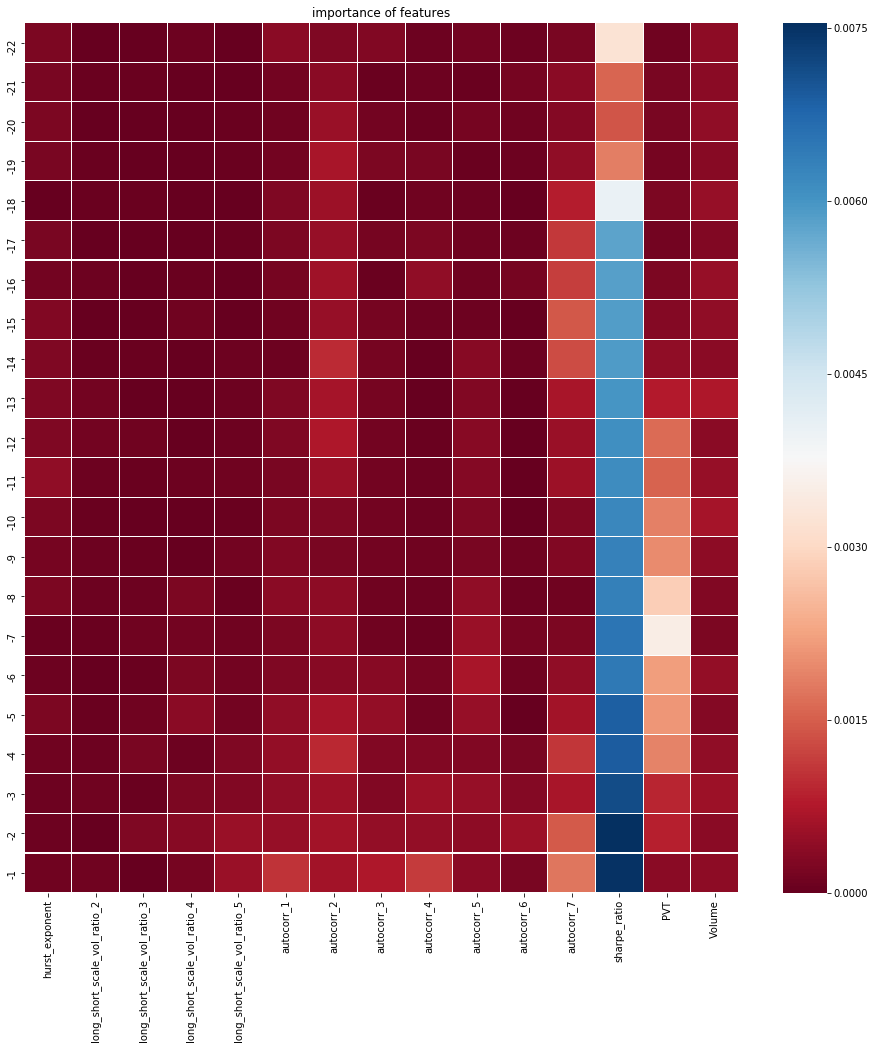

In [45]:
f, ax= plt.subplots(figsize = (16, 16))
sns.heatmap(impt, vmin=impt.values.min(), vmax=impt.values.max(),cmap="RdBu", linewidths = 0.05, ax = ax)
ax.set_title("importance of features")
plt.show()

#### Cross Validation

In [46]:
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(rnd_clf,X,y_positive,cv=5)

In [47]:
print("5-fold cross validation result:\n",", ".join(["%.4f%%"%(100*i) for i in cross_val_scores]))

5-fold cross validation result:
 78.3094%, 81.0207%, 78.8298%, 78.9362%, 78.4992%


The Accuracy are all around 75%, which seems pretty good. In the next stage, we plan to use the trained random forest as the indicator to improve the trading strategies.